## Skin Cancer Classification Transfer Learning EfficientNetB4

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn

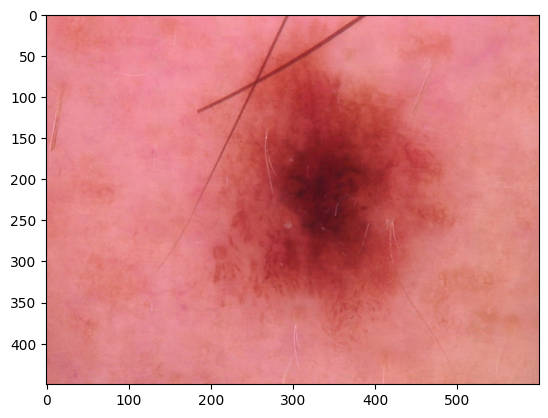

(450, 600, 3)


In [2]:
img = os.listdir('HAM_images')[0]
skin=cv2.imread('HAM_images/'+img)
plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
plt.show()

print(skin.shape)

In [3]:
mapping = {
    "MEL": 1,
    "NV": 2,
    "BCC": 3,
    "AKIEC": 4,
    "BKL": 5,
    "DF": 6,
    "VASC": 7
}

df_labels = pd.read_csv("HAM10000_metadata.csv")
newData = pd.DataFrame(columns=["image","MEL","NV","BCC","AKIEC","BKL","DF","VASC","label"])
for i in range(len(df_labels)):
    tempy = [0,0,0,0,0,0,0,0,0]
    tempy[0] = df_labels.iloc[i]["image_id"]
    tempy[-1] = df_labels.iloc[i]["dx"].upper()
    tempy[mapping[df_labels.iloc[i]["dx"].upper()]] = 1.0
    newData.loc[len(newData)] = tempy

df_labels.head(),newData

(     lesion_id      image_id   dx dx_type   age   sex localization
 0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
 1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
 2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
 3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
 4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear,
               image  MEL   NV  BCC  AKIEC  BKL   DF  VASC  label
 0      ISIC_0027419  0.0  0.0  0.0    0.0  1.0  0.0   0.0    BKL
 1      ISIC_0025030  0.0  0.0  0.0    0.0  1.0  0.0   0.0    BKL
 2      ISIC_0026769  0.0  0.0  0.0    0.0  1.0  0.0   0.0    BKL
 3      ISIC_0025661  0.0  0.0  0.0    0.0  1.0  0.0   0.0    BKL
 4      ISIC_0031633  0.0  0.0  0.0    0.0  1.0  0.0   0.0    BKL
 ...             ...  ...  ...  ...    ...  ...  ...   ...    ...
 10010  ISIC_0033084  0.0  0.0  0.0    1.0  0.0  0.0   0.0  AKIEC
 10011  ISIC_0033550  0.0  0.0  0.0    1.0  0.0  0.0   0.0  AKI

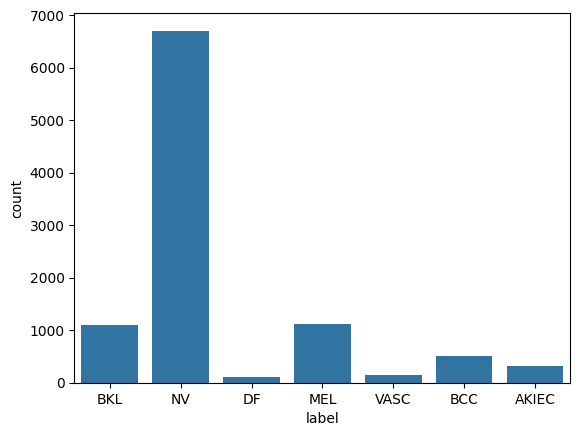

In [4]:
sns.countplot(x="label",data=newData)
plt.show()

### Train Test Split

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input as base_preprocess


image_gen = ImageDataGenerator(
                               preprocessing_function=base_preprocess,
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               # rescale=1/255,
                               validation_split=0.15)

2024-10-16 15:03:20.262505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 15:03:20.501857: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 15:03:20.563301: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 15:03:21.024021: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 15:03:23.178657: W tensorflow/compiler/tf2

In [6]:
data_dir = 'HAM_Dataset'
batch_size = 32
target_size = (224,224)
train_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size, 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

print(test_image_gen.class_indices)

Found 8516 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
{'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}


<Axes: ylabel='count'>

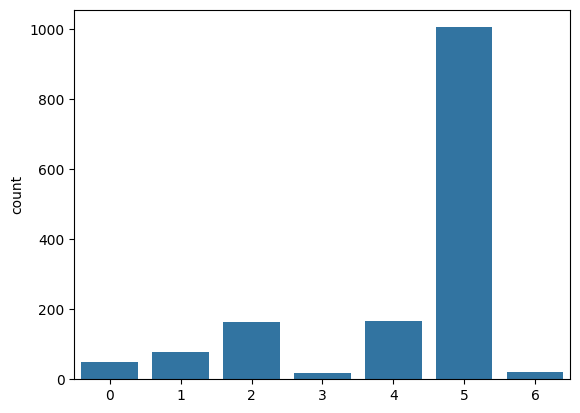

In [7]:
sns.countplot(x=test_image_gen.classes)

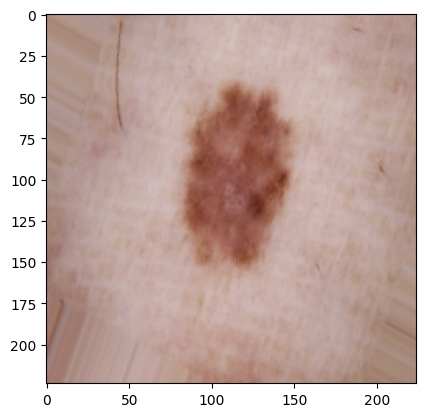

In [8]:
plt.imshow(train_image_gen[0][0][0]/255)

##     

## Transfer Learning using EfficientNetB4 Model

In [9]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(256,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)


tl_model.summary()

I0000 00:00:1729091006.809046     454 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729091007.341789     454 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729091007.341857     454 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729091007.345639     454 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729091007.345719     454 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      1,152 │ block1a_se_excit

 Total params: 18,134,630 (69.18 MB)

 Trainable params: 18,009,423 (68.70 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [10]:
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

### Model Training

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('efficientnet.keras',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

In [12]:
history = tl_model.fit(train_image_gen,
                    epochs=20, 
                    validation_data = test_image_gen,
                    callbacks=callback_list)

/home/blaise/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1729091069.297380     546 service.cc:146] XLA service 0x7f5448003c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729091069.297422     546 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-10-16 15:04:31.087338: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-16 15:04:38.158603: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-16 15:04:50.269234: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_45165', 32 bytes spill stores, 32 bytes spill loads

2024-10-16 15:04:50.358213: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in funct

 33/267 ━━━━━━━━━━━━━━━━━━━━ 2:07 546ms/step - accuracy: 0.3173 - loss: 6.2077

2024-10-16 15:06:34.710788: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_45163', 8 bytes spill stores, 8 bytes spill loads

2024-10-16 15:07:36.767474: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 28 bytes spill stores, 28 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 160 bytes spill stores, 160 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2', 172 bytes spill stores, 172 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_5', 44 bytes spill stores, 44 

267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 0.5818 - loss: 5.2621

2024-10-16 15:10:21.846740: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3996', 28 bytes spill stores, 28 bytes spill loads

2024-10-16 15:10:22.130572: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3996', 172 bytes spill stores, 172 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.77585, saving model to efficientnet.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 420s 1s/step - accuracy: 0.5822 - loss: 5.2596 - val_accuracy: 0.7759 - val_loss: 3.4953 - learning_rate: 1.0000e-04
Epoch 2/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.7817 - loss: 3.1435
Epoch 2: val_accuracy improved from 0.77585 to 0.82989, saving model to efficientnet.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 180s 672ms/step - accuracy: 0.7818 - loss: 3.1423 - val_accuracy: 0.8299 - val_loss: 2.2393 - learning_rate: 1.0000e-04
Epoch 3/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.8360 - loss: 2.0262
Epoch 3: val_accuracy improved from 0.82989 to 0.83989, saving model to efficientnet.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 177s 661ms/step - accuracy: 0.8360 - loss: 2.0255 - val_accuracy: 0.8399 - val_loss: 1.5183 - learning_rate: 1.0000e-04
Epoch 4/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.8683 - loss: 1.3437
Epoch 4: val_accuracy

### Model Evaluation

In [13]:
df=pd.DataFrame(tl_model.history.history)
df.to_csv('hist.csv')

<Axes: >

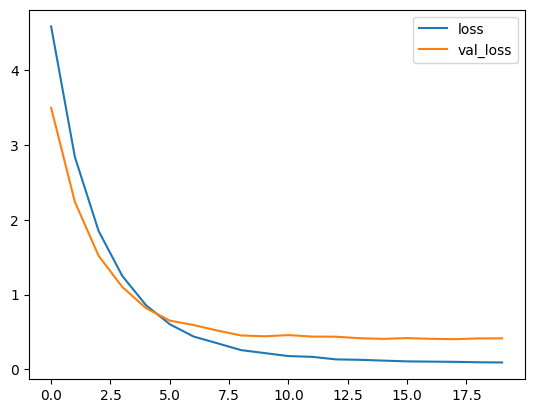

In [14]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

<Axes: >

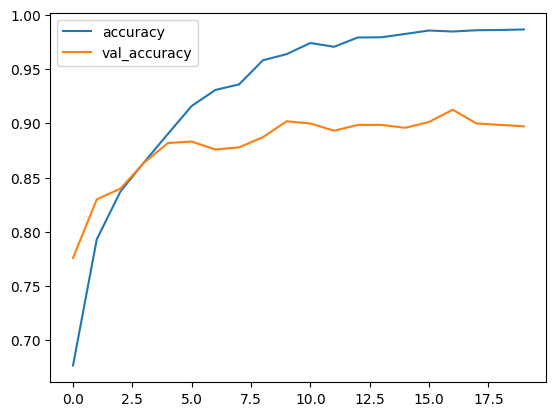

In [15]:
metrics[["accuracy","val_accuracy"]].plot()

In [16]:
tl_model.evaluate(test_image_gen)

47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 535ms/step - accuracy: 0.8457 - loss: 0.6276


[0.4004008173942566, 0.9046030640602112]

In [17]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)

test_labels = test_image_gen.classes

47/47 ━━━━━━━━━━━━━━━━━━━━ 43s 735ms/step


In [18]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(test_labels, predictions)

Normalized confusion matrix
[[7.75510204e-01 4.08163265e-02 1.02040816e-01 2.04081633e-02
  6.12244898e-02 0.00000000e+00 0.00000000e+00]
 [1.29870130e-02 8.70129870e-01 5.19480519e-02 0.00000000e+00
  0.00000000e+00 6.49350649e-02 0.00000000e+00]
 [3.65853659e-02 1.82926829e-02 7.62195122e-01 6.09756098e-03
  6.70731707e-02 1.09756098e-01 0.00000000e+00]
 [5.88235294e-02 0.00000000e+00 0.00000000e+00 8.82352941e-01
  5.88235294e-02 0.00000000e+00 0.00000000e+00]
 [1.20481928e-02 6.02409639e-03 7.22891566e-02 0.00000000e+00
  6.56626506e-01 2.28915663e-01 2.40963855e-02]
 [0.00000000e+00 9.95024876e-04 9.95024876e-03 0.00000000e+00
  1.29353234e-02 9.75124378e-01 9.95024876e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00]]


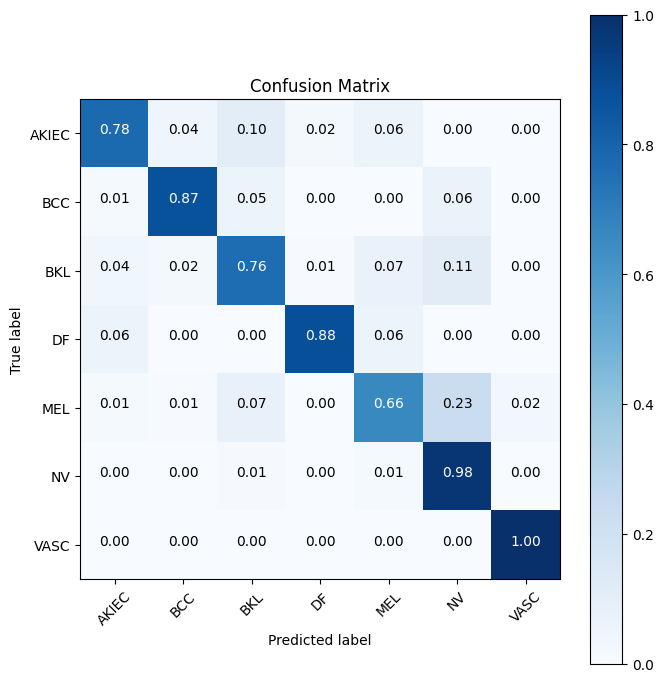

In [19]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cm_plot_labels = list(test_image_gen.class_indices.keys())

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [20]:
print(classification_report(test_image_gen.classes, predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.79      0.78      0.78        49
           1       0.91      0.87      0.89        77
           2       0.80      0.76      0.78       164
           3       0.88      0.88      0.88        17
           4       0.80      0.66      0.72       166
           5       0.94      0.98      0.96      1005
           6       0.81      1.00      0.89        21

    accuracy                           0.90      1499
   macro avg       0.85      0.85      0.84      1499
weighted avg       0.90      0.90      0.90      1499

